In [19]:
import pandas as pd

# Load JSON data into a DataFrame
df = pd.read_json('merged_sorted_intersections.json')

FEATURE ENGINEERING AND EXRTACTION

In [20]:
# Convert timestamps to datetime if they aren't already
df['timeStamp'] = pd.to_datetime(df['timeStamp'])

# Extract date and time components
df['hour'] = df['timeStamp'].dt.hour
df['minute'] = df['timeStamp'].dt.minute
df['second'] = df['timeStamp'].dt.second


# Assumption: 70% of cars go forward, 20% turn left, 10% turn right.
# These assumptions will be replaced with actual data in the future using sensors.
df['forward_flow'] = round(df['num_cars'] * 0.7)
df['left_flow'] = round(df['num_cars'] * 0.2)
df['right_flow'] = round(df['num_cars'] * 0.1)

# Calculate flow ratios for each direction
df['forward_flow_ratio'] = df['forward_flow'] / df['num_cars']
df['left_flow_ratio'] = df['left_flow'] / df['num_cars']
df['right_flow_ratio'] = df['right_flow'] / df['num_cars']


In [21]:
# Temporal Features based on trafficID
df['time_since_last_green'] = df.groupby('trafficID')['timeStamp'].diff().dt.total_seconds().fillna(0)

# Average time between green signals
df['avg_time_between_greens'] = df.groupby('trafficID')['timeStamp'].diff().dt.total_seconds().groupby(df['trafficID']).transform('mean').fillna(0)

In [22]:
# Peak flow is the maximum flow between the 3 directions
df['peak_flow'] = df[['forward_flow', 'left_flow', 'right_flow']].max(axis=1)

In [23]:
def categorize_time_of_day(hour):
    '''Categorize the time of day based on the hour of the day.'''
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['part_of_day'] = df['hour'].apply(categorize_time_of_day)

In [24]:
# Calculate the difference in car count between consecutive time stamps by traffic ID
df['car_count_diff'] = df.groupby('trafficID')['num_cars'].diff()

In [25]:
# Calculate the exponential moving average of the number of cars
df['ema_cars'] = df['num_cars'].ewm(span=10, adjust=False).mean()

In [26]:
# Create a columns to indicate whether the day is a weekend or not
df['weekday'] = df['timeStamp'].dt.weekday
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

In [27]:
# Create a column to indicate whether the day is a public holiday or not
public_holidays = set(['2024-09-23', '2025-02-22']) # Saudi National Day and Founding Day of the Kingdom of Saudi Arabia
df['is_public_holiday'] = df['timeStamp'].dt.date.astype(str).isin(public_holidays).astype(int)

In [28]:
import numpy as np
# Create a column to indicate the time of day as a sin/cos pair
period = 7 * 24  # 7 days * 24 hours
df['sin_time'] = np.sin(2 * np.pi * df['timeStamp'].dt.hour / period)
df['cos_time'] = np.cos(2 * np.pi * df['timeStamp'].dt.hour / period)


In [29]:
# Removing NaN values from car_count_diff column and setting them to 0
df['car_count_diff'].fillna(value=0, inplace=True)

C:\Users\omars\AppData\Local\Temp\ipykernel_16320\2924687809.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['car_count_diff'].fillna(value=0, inplace=True)


In [ ]:
# Group by date and trafficID, calculate the mean of the 3 flow directions, then calculate the mean of the 3 flow directions
daily_std_dev = df.groupby(['dateStamp', 'trafficID'])[['forward_flow', 'left_flow', 'right_flow']].std().mean(axis=1).reset_index()

# Rename the column for clarity
daily_std_dev.columns = ['dateStamp', 'trafficID', 'daily_std_dev']

# Merge the daily standard deviation back to the original DataFrame
df = pd.merge(df, daily_std_dev, on=['dateStamp', 'trafficID'])

In [39]:
# Number of features in dataset
len(df.columns)

27

MODEL TESTING/BUILDING

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras import Sequential

KeyboardInterrupt: 

In [ ]:
# Define your feature columns and target column
feature_cols = ['num_cars', 'sin_time', 'cos_time', 'is_weekend', 'ema_cars', 'car_count_diff']
target_col = 'greenTime'  # This should be the duration of green light or similar


In [ ]:
# Split the data into features and target
X = df[feature_cols]
y = df[target_col]


In [ ]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define X and y
X = df[feature_cols].values
y = df[target_col].values

# Reshape X for LSTM [samples, time steps, features]
X = X.reshape((X.shape[0], 1, X.shape[1]))

In [ ]:
# Split the data into training and testing sets chronologically
split_idx = int(len(X) * 0.8)  # 80% for training
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


In [ ]:
# Assuming 'scaler' is a StandardScaler instance
print('Feature means:', scaler.mean_)
print('Feature scales:', scaler.scale_)

# Check the maximum and minimum values of the scaled features
print('Max scaled features:', np.max(X_train, axis=0))
print('Min scaled features:', np.min(X_train, axis=0))


Feature means: [70.72372372  0.37519792  0.92679089  0.         71.12262799 -0.24698795]
Feature scales: [4.04559072e+01 1.56015113e-02 6.46235755e-03 1.00000000e+00
 1.20418145e+01 5.78391616e+01]
Max scaled features: [[190.           0.39989202   0.93087375   0.         106.42117303
  131.        ]]
Min scaled features: [[   0.            0.36534102    0.91656226    0.           43.77502754
  -146.        ]]


In [ ]:
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='rmse', metrics=['mae'])

NameError: name 'Sequential' is not defined

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 1974.1575 - mae: 42.7545 - val_loss: 1865.5691 - val_mae: 40.8136
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1843.0040 - mae: 40.8503 - val_loss: 1836.2214 - val_mae: 40.4536
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1827.8832 - mae: 40.5696 - val_loss: 1809.5737 - val_mae: 40.1224
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1856.6333 - mae: 41.1020 - val_loss: 1781.2552 - val_mae: 39.7717
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1834.7488 - mae: 40.7095 - val_loss: 1747.5168 - val_mae: 39.3568
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1778.7157 - mae: 40.0693 - val_loss: 1711.5459 - val_mae: 38.9067
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1768.8104 - mae: 40.0280 - val_loss: 1672.9440 - val_mae: 38.4142
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1700.1779 - mae: 39.2495 - val_loss: 1632.2177 - val_mae: 37.8899
Epoch 9/100
9/9

In [ ]:
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

NameError: name 'model' is not defined

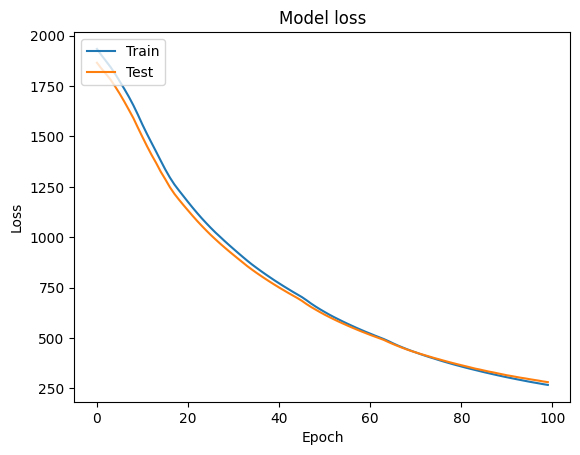

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
